In [1]:
import numpy as np
import chess
import pandas as pd
import io
import sys
import chess.pgn
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from python_code import pgn_to_fen

from sklearn.utils import shuffle
import gc
import chess.pgn

# print(sys.path)

### inspect raw data

In [72]:
pgn = open("data/raw_data/2019/ficsgamesdb_2019_CvH_nomovetimes_137574.pgn")
first_game = chess.pgn.read_game(pgn)

In [53]:
print(first_game)

[Event "FICS rated standard game"]
[Site "FICS freechess.org"]
[Date "2019.12.31"]
[Round "?"]
[White "GriffySr"]
[Black "gatorjoe"]
[Result "1-0"]
[BlackClock "0:15:00.000"]
[BlackElo "1839"]
[BlackRD "35.4"]
[ECO "C11"]
[FICSGamesDBGameNo "470001964"]
[PlyCount "85"]
[Time "23:38:00"]
[TimeControl "900+0"]
[WhiteClock "0:15:00.000"]
[WhiteElo "2234"]
[WhiteIsComp "Yes"]
[WhiteRD "26.4"]

1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Nfd7 5. f4 g6 6. Nf3 Bg7 7. Bd3 O-O 8. O-O Re8 9. Be3 a6 10. Ng5 h6 11. Nf3 Qe7 12. Qd2 Nb6 13. f5 exf5 14. Bxh6 Be6 15. Bxg7 Kxg7 16. Ng5 Rh8 17. Qf4 Rh5 18. h4 c5 19. Be2 Nc6 20. Bxh5 gxh5 21. dxc5 Qxc5+ 22. Kh1 Qe7 23. Qf3 Rh8 24. Qg3 Kf8 25. Rad1 d4 26. Ne2 Qc5 27. c3 dxc3 28. Qxc3 Qxc3 29. Nxc3 Ke7 30. g3 Nc4 31. Rf2 Ne3 32. Rd3 Ng4 33. Re2 Nb4 34. Rd6 Rc8 35. Rb6 Rc4 36. Rxb7+ Kf8 37. Ra7 Rc6 38. Rd2 Bc4 39. b3 Be6 40. Rd4 Nc2 41. Rd6 Rxc3 42. Nxe6+ fxe6 43. Rd8# { Black checkmated } 1-0


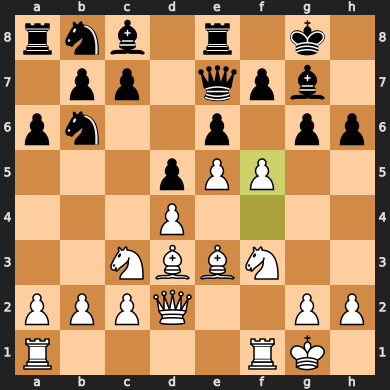

In [57]:
board = first_game.board()
moves = list(first_game.mainline_moves())
move_to_show = 25

for move in moves[:move_to_show]:
     board.push(move)
board

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR


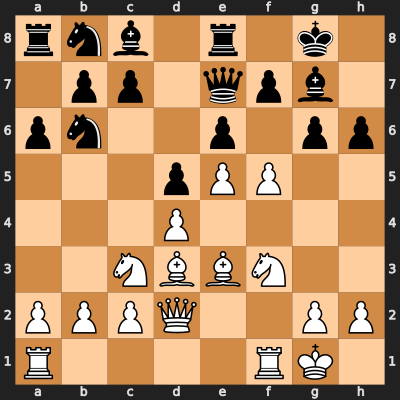

In [94]:
fen1 = board.board_fen()
fen2 = chess.Board().board_fen()
print(fen2)

baseboard1 = chess.BaseBoard(fen1)
baseboard1

In [54]:
# attackers = board.attackers(chess.WHITE, chess.F3)
# print(attackers)

<class 'chess.SquareSet'>
P
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


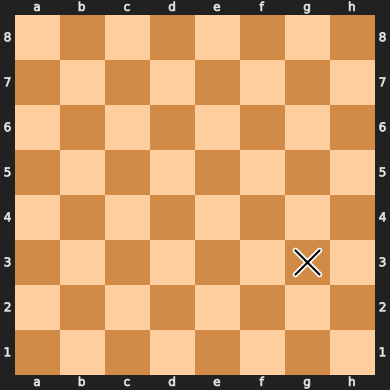

In [91]:
pos=15
a1 = baseboard1.attacks(pos) # which fields are attacked from field 9 (=B2, the pawn)
print(type(a1))
print(baseboard1.piece_at(pos))
a1_list = a1.tolist()
print(a1_list)
a1


In [96]:
5//2

2

### Data preprocessing and exploration
* only take games where the human player loses
* time controls: 5, 10, 15, 20 minutes. shorter games are harder to cheat because it takes a few seconds per move to let the engine run.
* balance data so that the opponent is 50 percent human or computer
* only take games that lasted more than 40 half moves

In [41]:
df_2018 = pd.read_json("data/raw_data/json/2018/join_data.json")
df_2017 = pd.read_json("data/raw_data/json/2017/join_data.json")

In [43]:
df_2017["TimeControl"].value_counts().sort_values(ascending=False).head(20)

180+0     86781
300+0     66833
900+0     34073
60+0      25736
120+12     6949
120+0      5439
600+0      5391
900+5      4583
300+5      3677
0+4        3292
3600+0     2438
300+12     2437
1200+0     2087
180+2      1773
720+5      1652
240+0      1638
900+10     1535
120+1      1426
600+5      1307
300+3      1293
Name: TimeControl, dtype: int64

In [30]:
games_white_human = pd.read_parquet("data/preprocessed/games_white_human.parquet")
games_black_human = pd.read_parquet("data/preprocessed/games_black_human.parquet")

In [32]:
def plotGameLengths(df):
    df["gameLength"]=df["moves"].apply(lambda x: len(x))
    plt.hist(df["gameLength"], bins=range(120))
    plt.xlim([0,120])
    plt.xlabel("moves (ply)")
    plt.ylabel("frequency")
    plt.title("histogram of game lengths (half moves)")
    print("mean game length = " + str(np.mean(df["gameLength"])) + " ply")
    plt.show()

mean game length = 61.66785778095408 ply


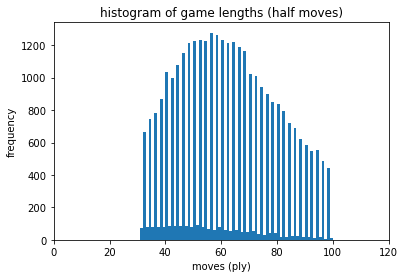

In [33]:
plotGameLengths(games_white_human)

mean game length = 60.979988741908244 ply


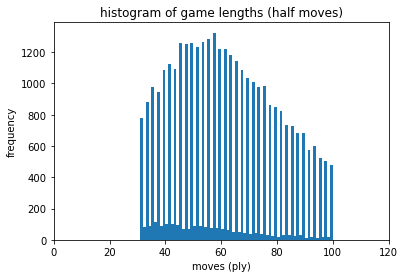

In [34]:
plotGameLengths(games_black_human)

In [56]:
array_black = np.load("data/preprocessed/fen_black_human.npy.npz")
array_white = np.load("data/preprocessed/fen_white_human.npy.npz")

print(array_black["arr_0"].shape)
print(array_white["arr_0"].shape)

(31636, 20, 12, 8, 8)
(30230, 20, 12, 8, 8)


### Heatmaps

In [17]:
def fen_to_heatmap(piece, fenlist):
    heatmap=np.zeros((8,8))
    for fen in fenlist:                  
        for k in range(8):
            index=[i for i, pc in enumerate(fen[k]) if pc==piece]
            for i in index:
                heatmap[k][i]+=1
    heatmap=heatmap/len(fenlist)
    return heatmap

In [18]:
def moves_to_heatmap(moves,piece):
    fenlist=moves_to_fen(moves)
    heatmap=fen_to_heatmap(piece, fenlist)
    return heatmap

In [19]:
# get average heatmap over n_av games
def average_heatmap(piece, n_av, pgns):
    avHeatmap=np.zeros((8,8))
    for pgn in pgns[:n_av]:
        heatmap=moves_to_heatmap(pgn, piece)
        avHeatmap+=heatmap
    avHeatmap/=n_av
    return avHeatmap

In [20]:
def display_heatmap(piece, n_av, pgn):
    heatmap=average_heatmap(piece, n_av, pgn)
    ax=sns.heatmap(heatmap,xticklabels=["A","B","C","D","E","F","G","H"],yticklabels=[8,7,6,5,4,3,2,1])
    if piece.isupper():
        color = "white "
    else:
        color = "black "
    ax.set_title('Heatmap for '+ color +  piece)
    return ax

In [21]:
def displayMultHeatmap(pieces, n_av, pgn):
    for piece in pieces:
        heatmap=average_heatmap(piece, n_av, pgn)
        ax=sns.heatmap(heatmap,xticklabels=["A","B","C","D","E","F","G","H"],yticklabels=[8,7,6,5,4,3,2,1])
        if piece.isupper():
            color = "white "
        else:
            color = "black "
        ax.set_title('Heatmap for '+ color +  piece)
    
    return ax

In [22]:
pgn_whiteH=df['moves'][df.WhiteIsComp==0]
pgn_blackH=df['moves'][df.BlackIsComp==0]
pgn_blackC=df['moves'][df.BlackIsComp==1]

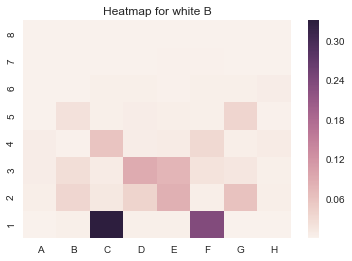

In [63]:
display_heatmap("B", 1000, pgn_whiteH)

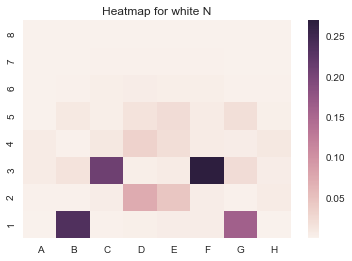

In [64]:
display_heatmap("N", 1000, pgn_whiteH)

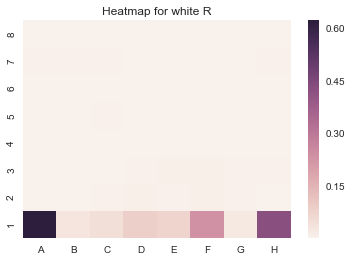

In [52]:
display_heatmap("R", 1000, pgn_whiteH)

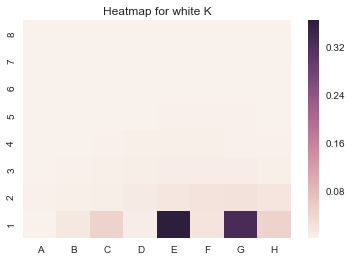

In [53]:
display_heatmap("K", 1000, pgn_whiteH)

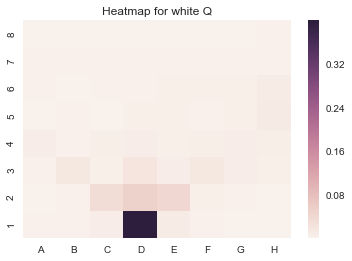

In [65]:
display_heatmap("Q", 1000, pgn_whiteH)

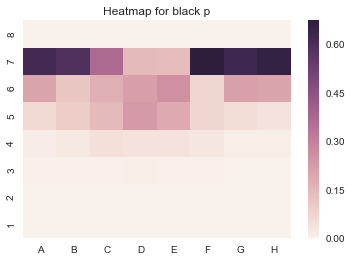

In [23]:
display_heatmap("p", 1000, pgn_blackH)

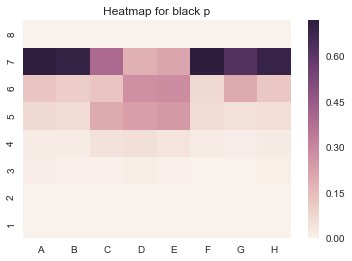

In [24]:
display_heatmap("p", 1000, pgn_blackC)